# Goal Of this notebook

* Import Data
* Visualize Data
* Prepare Data
* Callbacks

## Import Data

In [1]:
import zipfile

def import_data():
  #!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

  zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
  zip_ref.extractall()
  zip_ref.close()

import_data()

## Visualize Data

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


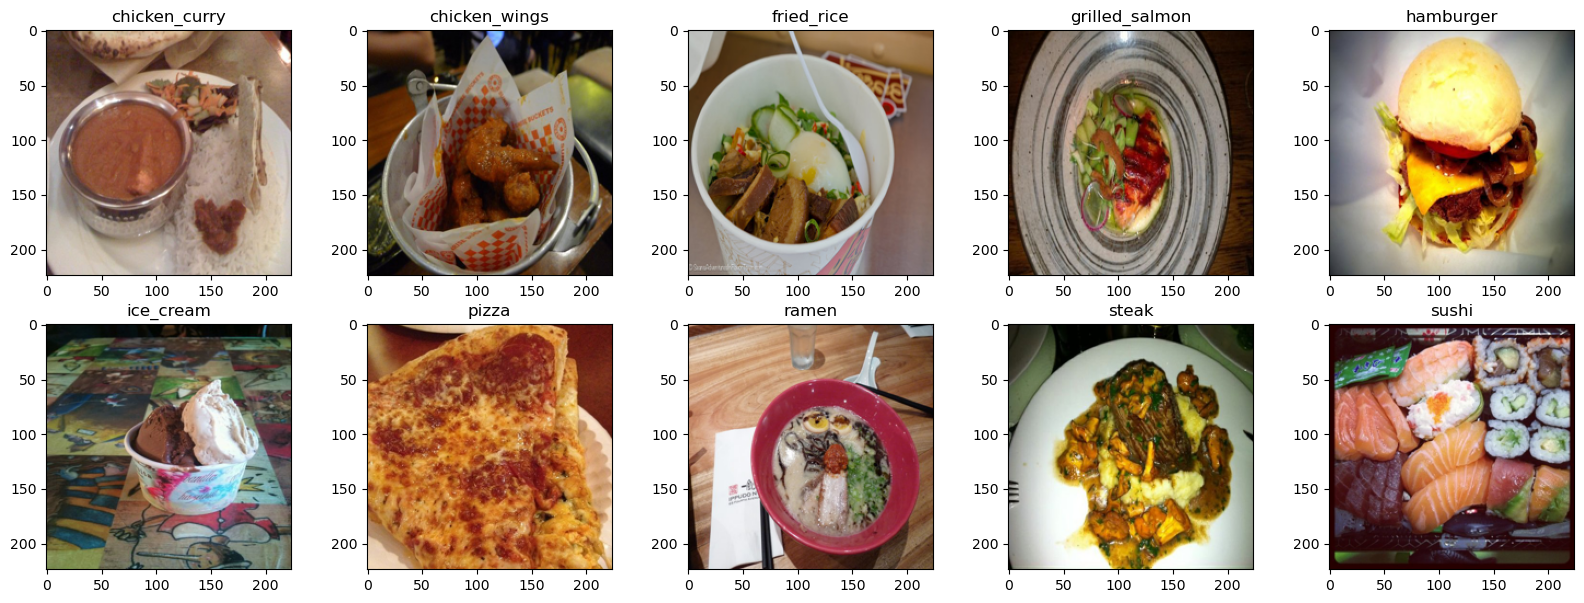

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def visualize_data():
  train_dir = '10_food_classes_10_percent/train'
  dirs = os.listdir(train_dir)
  images = []
  print(dirs)
  for dir in dirs:
    file_dir = train_dir + '/' + dir + '/'
    files = os.listdir(file_dir)
    random_file = random.choice(files)
    random_img = file_dir + random_file
    img = Image.open(random_img)
    img = img.resize((224,224))
    images.append(img)
    #print(img.size)
  rows = 2
  cols = 5
  i = 0
  fig,axes = plt.subplots(rows,cols,figsize=(20,7))
  for row in range(rows):
    for col in range(cols):
      axes[row,col].imshow(images[i])
      axes[row,col].set_title(dirs[i])
      i = i + 1

visualize_data()

## Preprocess Data

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '10_food_classes_10_percent/train'
test_dir  = '10_food_classes_10_percent/test'
IMG_SIZE  = (224,224)
train_data_gen = ImageDataGenerator(rescale=1/255.)
train_data = train_data_gen.flow_from_directory(directory=train_dir,
                                                target_size=IMG_SIZE)
test_data_gen = ImageDataGenerator(rescale=1./255)
test_data = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size= IMG_SIZE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Tensorflow Callbacks

* **BackupAndRestore** - Intended to recover from an interruption in the middle of model.fit() function.
* **EarlyStopping** - Stops the training if the loss is not improving after n epochs of patience.
* **LambdaCallback** - This callback is constructed with anonymous function to be invoked  during fit, predict and evalate steps.
* **LearningRateScheduler** - To update randomly the learning rate to find the best learning rate.
* **ModelCheckpoint** - Used in conjunction with Fit Function to store the model weights at some interval.
* **ProgbarLogger** - Prints metrics to stdout.
* **ReduceLROnPlateau** - Reduces the learning rate if no loss improvement is observed after n no of patience epochs.
* **RemoteMonitor** - Stream events to server
* **SidecarEvaluatorModelExport** - Exports the best model after evaluation with validation dataset.
* **TensorBoard** - Enable visualization for TensorBoard.
* **TerminateOnNaN** - Terminates the training when a NaN loss is encountered.
* **BaseLogger** and **History** Callbacks are auto applied to every keras model.

In [4]:
# create tensorboard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'saving tensorboard log files to : {log_dir}')
    return tensorboard_callback

# Creating Models using Tensorflow Hub

* resent url - https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
* efficientnet url - https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

IMG_SHAPE = (224,224)

def create_trained_model(model_url,num_classes=10):
    """
    Takes a tensorflow hub url and creates a Keras Sequential model.
    """
    feature_extraction_layer = hub.KerasLayer(model_url,
                                              trainable=False,
                                              name='feature_extraction_layer',
                                             input_shape=IMG_SHAPE+(3,))
    model = Sequential([
        feature_extraction_layer,
        Dense(num_classes,activation='softmax',name='output_layer')
    ])
    return model

In [13]:
# create model
RESNET_MODEL_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
NUM_LABELS = train_data.num_classes
model = create_trained_model(RESNET_MODEL_URL,num_classes=NUM_LABELS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [18]:
model.fit(train_data,epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
         callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='resnet_v2_50')])

saving tensorboard log files to : tensorflow_hub/resnet_v2_50/20230329-115433
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.9019 - accuracy: 0.7200

KeyboardInterrupt: 